# Fourier Playground

You will learn here how to generate a 1D Gaussian random field and you will look at the effect of a Fourier mode

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
show_plot=True

In [2]:
# number of cells (power of two is usually good)
N=2**6
# number of Fourier modes
NF=int(N/2+1)
# length of array, and cell width
dx = 1
L = dx * N
# random seed
seed=1234
# setup random number generator using seed
gen = np.random.RandomState(seed)

In [3]:
# test the random number generator
gen.normal(size=1)

array([0.47143516])

Note that gen.normal will use a normal distribution, i.e., Gaussian distribution with zero mean and unit variance. If we generate many random numbers, we can check that indead we measure a mean and a variance consistent with that. However, there will be noise in the measurement, so the more numbers you generate the closer you will be to the actual mean and variance

In [4]:
test_10=gen.normal(size=10)
test_1000=gen.normal(size=1000)
test_1M=gen.normal(size=1000000)
print('using 10 numbers, mean=%f, variance=%f' % (np.mean(test_10),np.var(test_10)) )
print('using 1000 numbers, mean=%f, variance=%f' % (np.mean(test_1000),np.var(test_1000)) )
print('using 1000000 numbers, mean=%f, variance=%f' % (np.mean(test_1M),np.var(test_1M)) )

using 10 numbers, mean=-0.075823, variance=1.231416
using 1000 numbers, mean=0.013076, variance=0.947266
using 1000000 numbers, mean=-0.000338, variance=1.001631


### Input power spectrum

The power spectrum will deteremine how much structure is there as a funciton of scale

In [5]:
def power(k,k0=0.05):
    """Define here your favorite power spectrum. Mine is a Gaussian around log k0."""
    P = np.zeros_like(k)
    # avoid log(k=0)
    nonzero = (k>0)
    P[nonzero] = np.exp(-np.log(k[nonzero]/k0)**2)
    return P

In this notebook we will play with three universes with different power spectra, peaked on different scales

In [6]:
universes=[]
universes.append({'label':r'$k_0=0.1$','color':'blue','k_0':0.1})
universes.append({'label':r'$k_0=0.2$','color':'red','k_0':0.2})
universes.append({'label':r'$k_0=0.5$','color':'black','k_0':0.5})

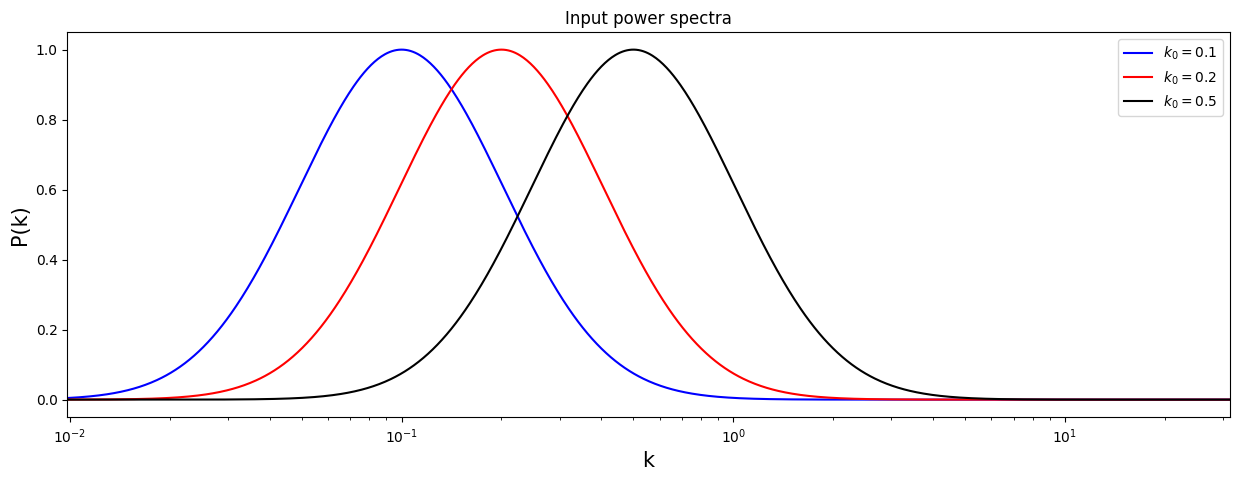

In [7]:
if show_plot:
    kmin=0.1*2*np.pi/L
    kmax=10*np.pi/dx
    kplot=np.logspace(np.log10(kmin),np.log10(kmax),1000)
    plt.xlim(kmin,kmax)
    plt.xlabel('k',fontsize=15)
    plt.ylabel('P(k)',fontsize=15)
    for uni in universes:
        P=power(kplot,uni['k_0'])
        plt.semilogx(kplot,P,label=uni['label'],color=uni['color'])
    plt.title('Input power spectra')
    plt.legend()

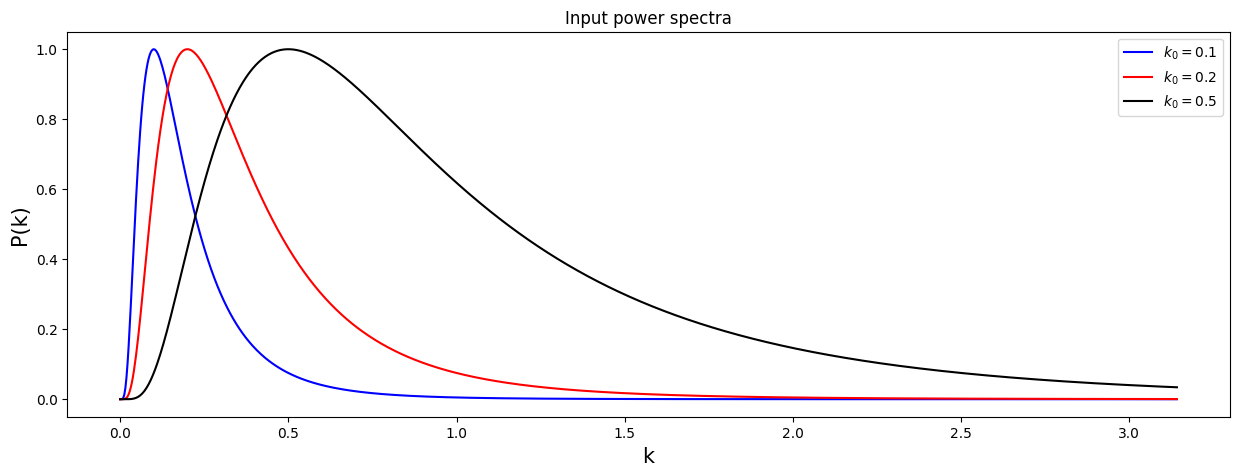

In [8]:
# same but not using log-scale in x axis
if show_plot:
    kmin=2*np.pi/L
    kmax=np.pi/dx
    kplot=np.linspace(0.,kmax,1000)
    for uni in universes:
        P=power(kplot,uni['k_0'])
        plt.plot(kplot,P,label=uni['label'],color=uni['color'])
    plt.xlabel('k',fontsize=15)
    plt.ylabel('P(k)',fontsize=15)
    plt.title('Input power spectra')
    plt.legend()

### Generate random Fourier modes (complex numbers)

In [9]:
def get_gaussian_modes(k0=1.0,new_seed=None):
    """Generate Gaussian random numbers for the Fourier modes of the grid.
    
    k0 is used by power spectrum, new_seed is useful to ensure same seed in fields"""
    if new_seed:
        gen = np.random.RandomState(new_seed)
        
    # get frequencies (wavenumbers)
    k = np.fft.rfftfreq(N)*2*np.pi/dx
    # get power evaluated at each k
    P = power(k,k0)

    # generate random Fourier modes (1 field only)
    Ns=1
    modes = np.empty([Ns,NF], dtype=complex)
    modes[:].real = np.reshape(gen.normal(size=Ns*NF),[Ns,NF])
    modes[:].imag = np.reshape(gen.normal(size=Ns*NF),[Ns,NF])
    # normalize to desired power (and enforce real for i=0, i=NF-1)
    modes[:,0] = modes[:,0].real * np.sqrt(P[0])
    modes[:,-1] = modes[:,-1].real * np.sqrt(P[-1])
    modes[:,1:-1] *= np.sqrt(0.5*P[1:-1])    
    return modes[0]

We will generate 3 sets of Fourier modes using different input power spectra, but the same random numbers

In [10]:
for uni in universes:
    modes=get_gaussian_modes(uni['k_0'],seed)
    uni['modes']=modes

In [11]:
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.rfftfreq(N)*2*np.pi/dx

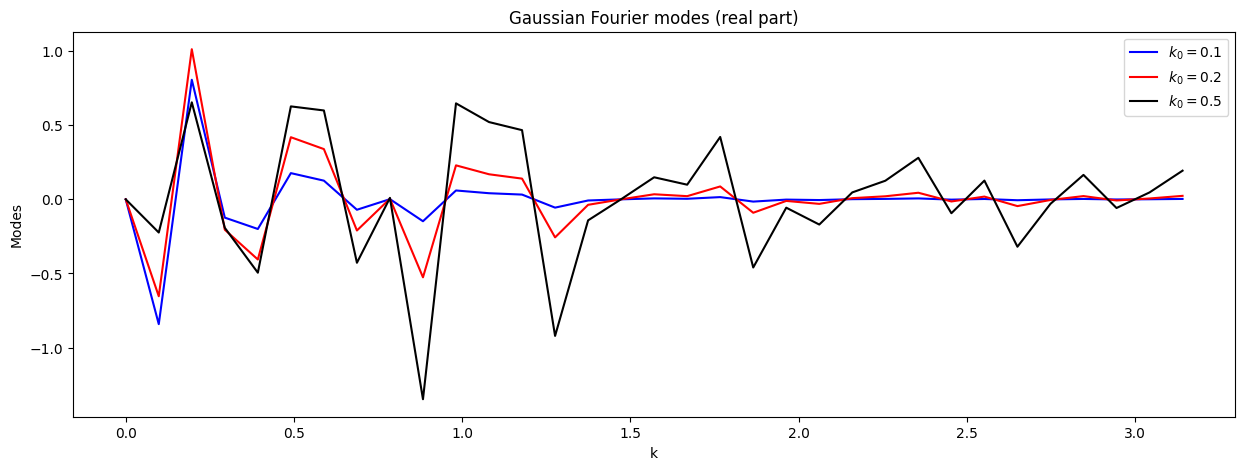

In [12]:
if show_plot:
    for uni in universes:
        plt.plot(k,uni['modes'].real,label=uni['label'],color=uni['color'])
    plt.xlabel('k')
    plt.ylabel('Modes')
    plt.title('Gaussian Fourier modes (real part)')
    plt.legend()

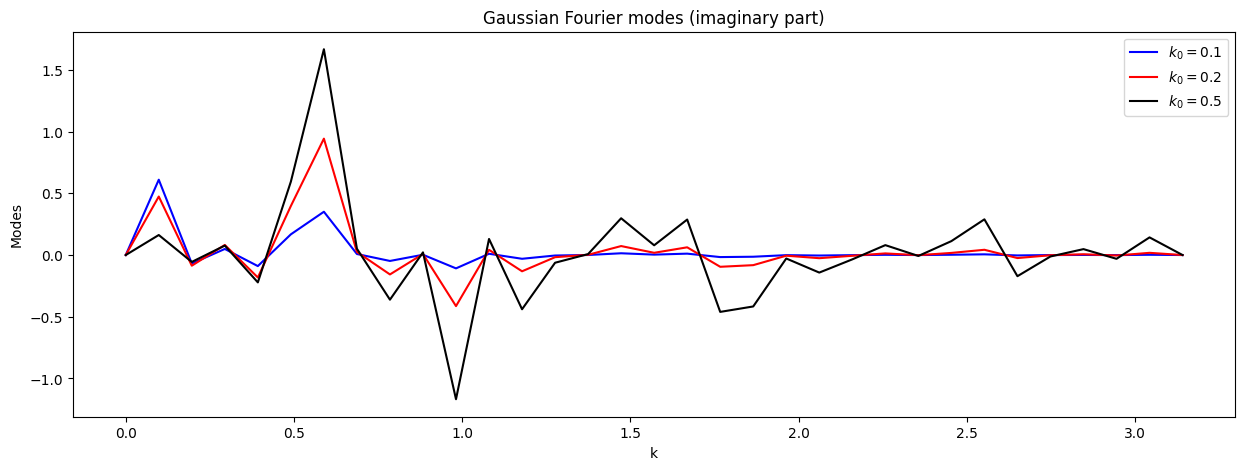

In [13]:
if show_plot:
    for uni in universes:
        plt.plot(k,uni['modes'].imag,label=uni['label'],color=uni['color'])
    plt.xlabel('k')
    plt.ylabel('Modes')
    plt.title('Gaussian Fourier modes (imaginary part)')
    plt.legend()

### Generate density fields from the random Fourier modes

In [14]:
def get_field(modes):
    """Given a set of Fourier modes, compute inverse Fourier transform to get a field"""
    if NF != len(modes):
        print('size mismatch',NF,len(modes))
        raise SystemExit
    # inverse FFT to get (normalized) delta field
    delta = np.fft.irfft(modes) * np.sqrt(N/dx)
    return delta

def get_modes(delta):
    """Given a delta field, return set of Fourier modes using FFT"""
    if N != len(delta):
        print('size mismatch',N,len(delta))
        raise SystemExit
    # inverse FFT to get (normalized) delta field
    modes = np.fft.rfft(delta) / np.sqrt(N/dx)
    new_delta = np.fft.irfft(modes) * np.sqrt(N/dx)
    return modes

def get_gaussian_field(k0=0.01,new_seed=None):
    """Generate a set of random Fourier modes, and use them to get a field"""
    modes = get_gaussian_modes(k0,new_seed)
    return get_field(modes)

In [15]:
# Inverse Fourier transform to get the density fluctuations
for uni in universes:
    uni['deltas']=get_field(uni['modes'])

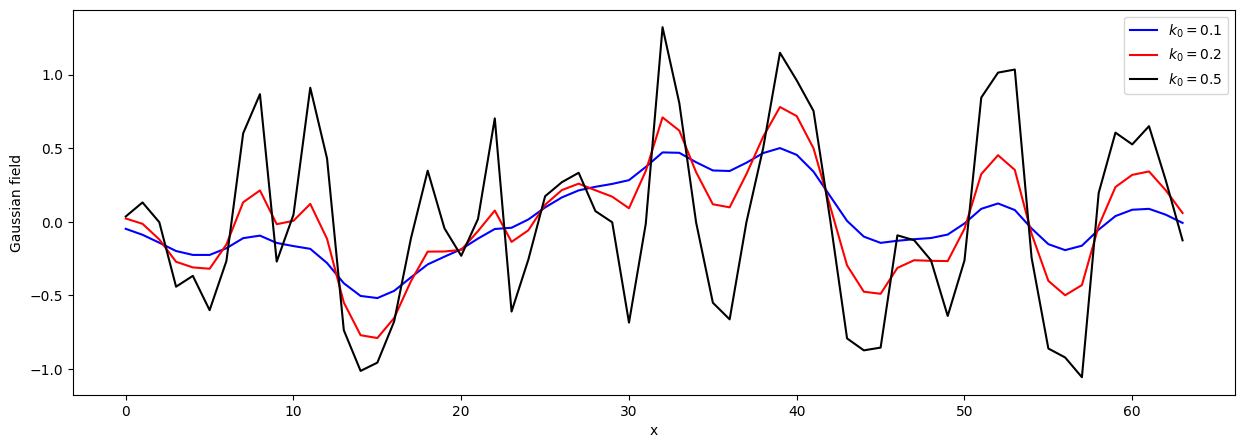

In [16]:
# position of cells in skewers
x = dx*np.arange(N)
if show_plot:
    for uni in universes:
        plt.plot(x,uni['deltas'],label=uni['label'],color=uni['color'])
    if N>100:
        plt.xlim(0.0,100.0*dx)
    plt.xlabel('x')
    plt.ylabel('Gaussian field')
    plt.legend()

### Check agreement with input power

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

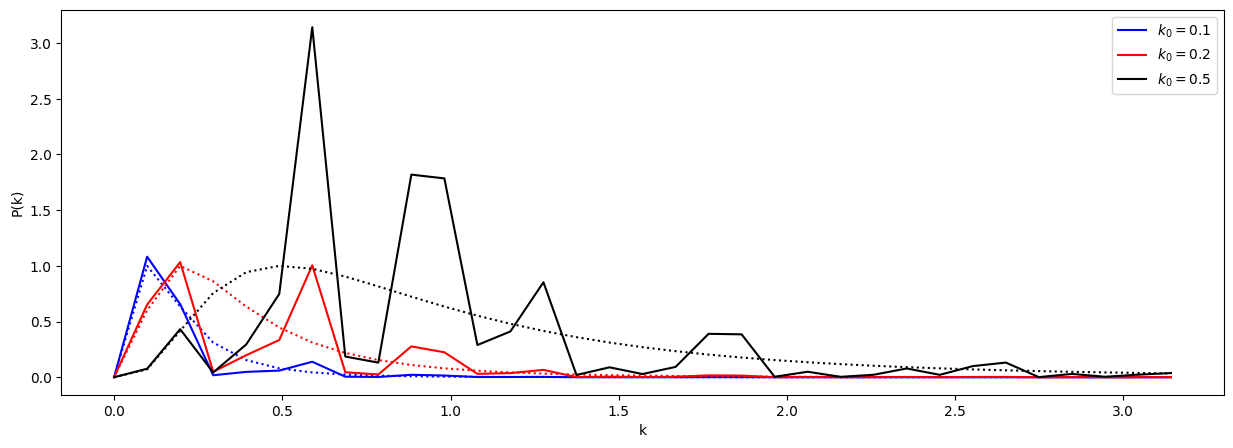

In [17]:
if show_plot:
    for uni in universes:
        plt.plot(k,abs(uni['modes'])**2,label=uni['label'],color=uni['color'])
        plt.plot(k,power(k,uni['k_0']),color=uni['color'],ls=':')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend()

The plot above is very noisy, be cause the amplitude of each Fourier mode itself is a random number. We could average multiple realisations (multiple fake universes), but we could also compute the average power over neighbouring wavenumbers.

In [18]:
def binned_power(k,Pk,Nrebin):
    if NF != len(Pk):
        print('size mismatch',NF,len(Pk))
        raise SystemExit
    Nk=int(NF/Nrebin)
    #print('NF',NF)
    #print('Nk',Nk)
    binned_k = np.zeros(Nk)
    binned_Pk = np.zeros(Nk)
    binned_var_Pk = np.zeros(Nk)
    for i in range(0,NF):
        ibin=int(i/Nrebin)
        if ibin==Nk:
            continue
        binned_k[ibin] += k[i]
        binned_Pk[ibin] += Pk[i]
        binned_var_Pk[ibin] += Pk[i]*Pk[i] 
    for ibin in range(0,Nk):
        binned_k[ibin] /= Nrebin
        binned_Pk[ibin] /= Nrebin
        # variance in binned power
        binned_var_Pk[ibin] /= (Nrebin-1)
        binned_var_Pk[ibin] -= binned_Pk[ibin]*binned_Pk[ibin]
        # error in mean of binned power
        binned_var_Pk[ibin] /= Nrebin
    return binned_k, binned_Pk, binned_var_Pk

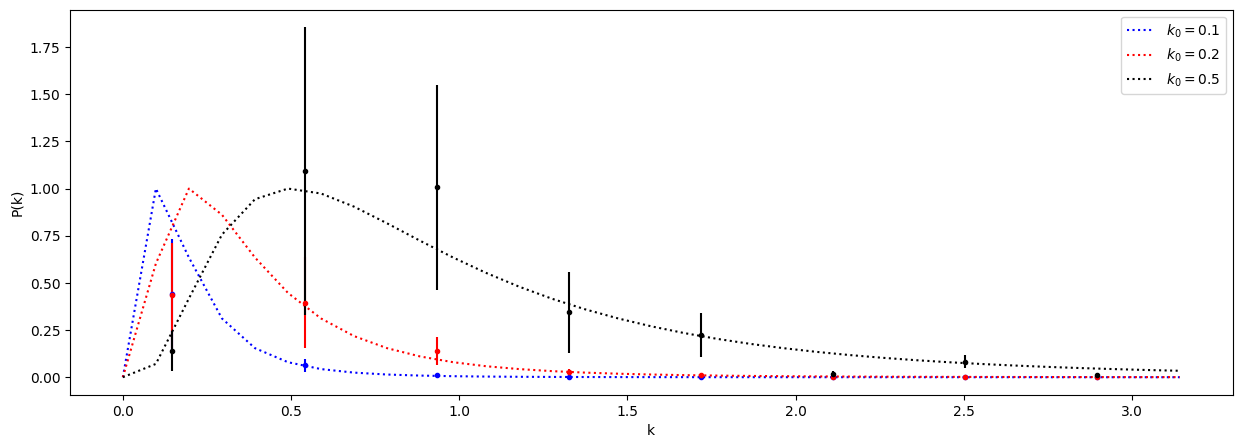

In [19]:
# specify how many points we want to rebin
Nrebin=2**2
for uni in universes:
    bin_k,bin_Pk,bin_var_Pk = binned_power(k,abs(uni['modes'])**2,Nrebin)
    uni['bin_Pk']=bin_Pk
    uni['bin_var']=bin_var_Pk

if show_plot:   
    for uni in universes:
        plt.errorbar(bin_k,uni['bin_Pk'],yerr=np.sqrt(uni['bin_var']),fmt='.',color=uni['color'])
        plt.plot(k,power(k,uni['k_0']),color=uni['color'],ls=':',label=uni['label'],)
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend()

## Messing around with a single Fourier mode
In order to show the role of a given Fourier mode, we will mess around with the one of the lower-k mode.

### Modifying the amplitude
We will start by boosting the amplitude of the mode.

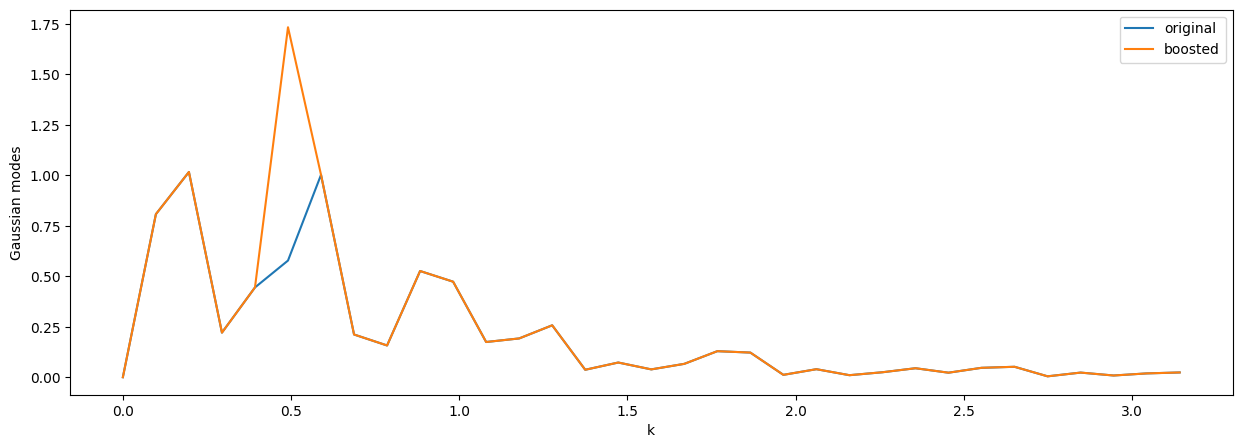

In [20]:
modes=universes[1]['modes']
deltas=get_field(modes)
# make a copy to be modified
new_modes=np.copy(modes)
# specify mode to modify
iboost=5
# specify amplitude of boost
Aboost=3.0
new_modes[iboost] *= Aboost
if show_plot:
    plt.plot(k,abs(modes),label='original')
    plt.plot(k,abs(new_modes),label='boosted')
    plt.xlabel('k')
    plt.ylabel('Gaussian modes')
    plt.legend()

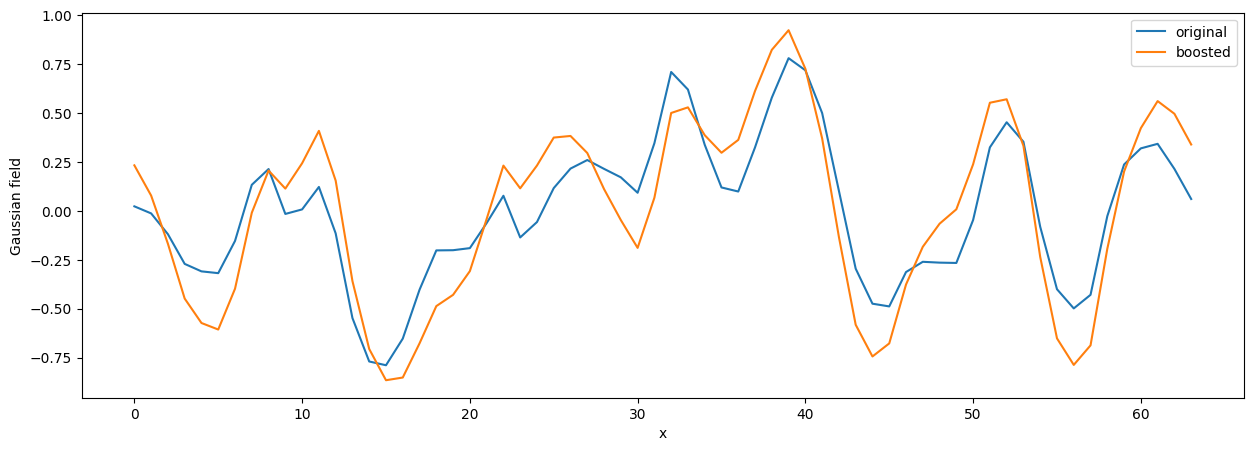

In [21]:
new_deltas=get_field(new_modes)
if show_plot:
    plt.plot(x,deltas,label='original')
    plt.plot(x,new_deltas,label='boosted')
    plt.xlabel('x')
    plt.ylabel('Gaussian field')
    plt.legend()

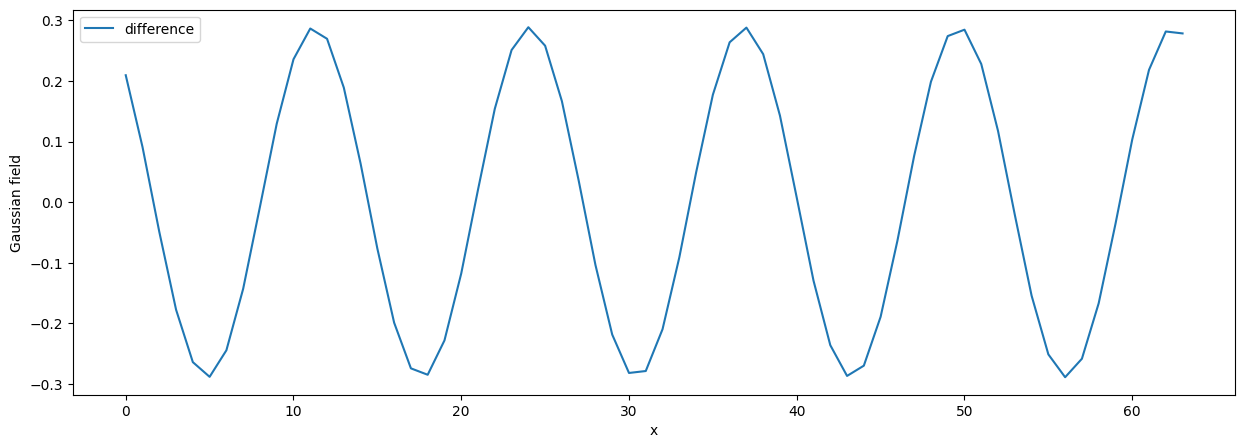

In [22]:
if show_plot:
    plt.plot(x,new_deltas-deltas,label='difference')
    plt.xlabel('x')
    plt.ylabel('Gaussian field')
    plt.legend()

### Modifying the phase
We can also vary the phase of the Fourier mode, without changing the overall amplitude (it is a complex number!)

In [23]:
boosted_amp=abs(new_modes[iboost])
boosted_angle=np.angle(new_modes[iboost])
print('angle of boosted mode =',boosted_angle)

angle of boosted mode = 0.7590927815528705


We will create four new Fourier modes where the boosted power has different angles

In [24]:
# start by creating new copies of the original modes
universes=[]
universes.append({'label':'+0 deg','angle':0,'modes':np.copy(modes)})
universes.append({'label':'+90 deg','angle':0.5*np.pi,'modes':np.copy(modes)})
universes.append({'label':'+180 deg','angle':np.pi,'modes':np.copy(modes)})
universes.append({'label':'+270 deg','angle':1.5*np.pi,'modes':np.copy(modes)})
# now boost the Fourier mode with different angles
for uni in universes:
    uni['modes'][iboost] = boosted_amp * np.exp(1j*(boosted_angle+uni['angle']))
    uni['deltas']=get_field(uni['modes'])

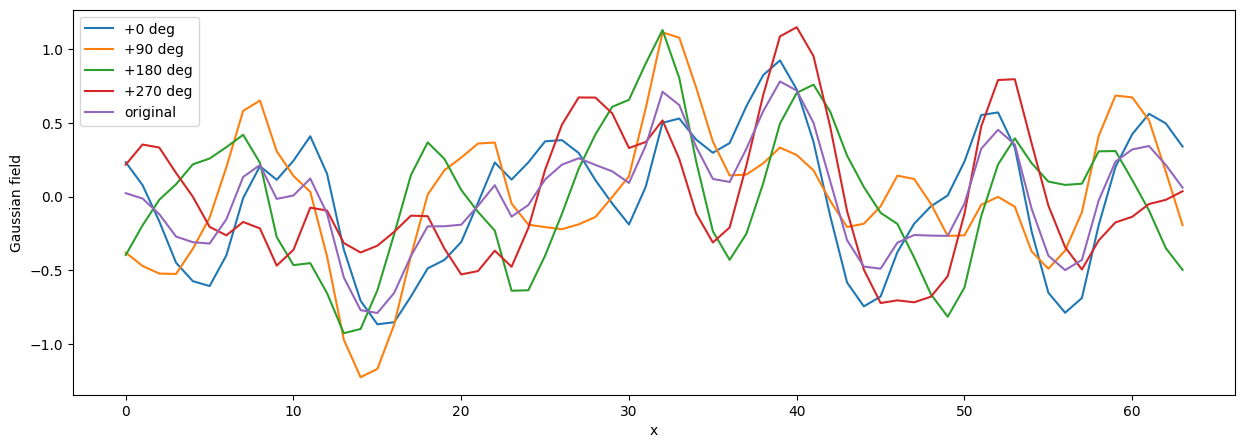

In [25]:
if show_plot:
    for uni in universes:
        plt.plot(x,uni['deltas'],label=uni['label'])
    plt.plot(x,deltas,label='original')
    plt.xlabel('x')
    plt.ylabel('Gaussian field')
    plt.legend()

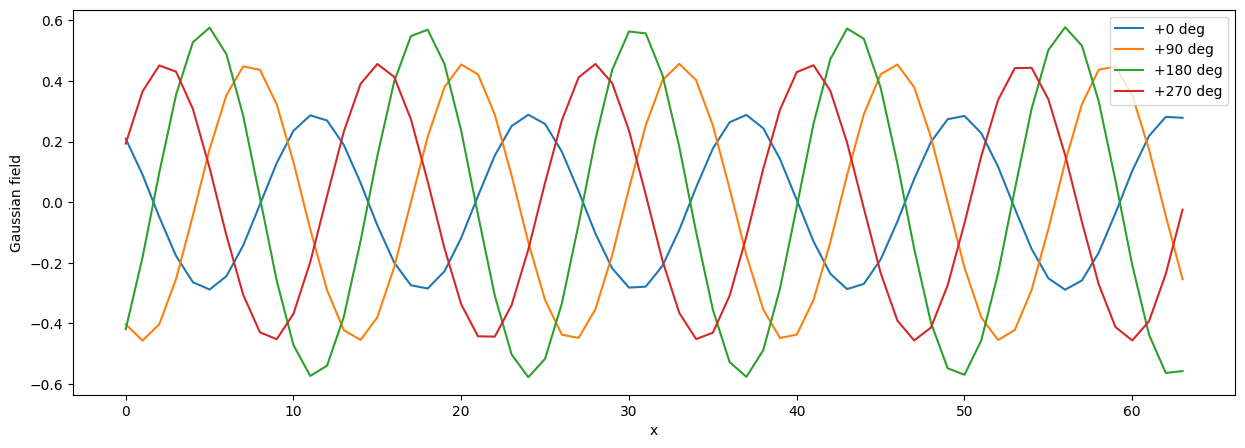

In [26]:
if show_plot:
    for uni in universes:
        plt.plot(x,uni['deltas']-deltas,label=uni['label'])
    plt.xlabel('x')
    plt.ylabel('Gaussian field')
    plt.legend()